In [1]:
!pip install rarfile

In [2]:
!pip install nnfs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
import gzip
import pickle
import os

In [5]:
from nnfs.datasets import spiral_data

# Initialize data
X, Y = spiral_data(100, 3)  # 100 points per class, 3 classes

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients with respect to weights
        self.dweights = np.dot(self.inputs.T, dvalues)
        # Gradients with respect to biases
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradients with respect to inputs (for the layer below)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.zeros_like(dvalues)
        # For each sample, compute Jacobian matrix
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten
            single_output = single_output.reshape(-1, 1)
            # Jacobian matrix of softmax
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calc gradient + store
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_crossentropy(Loss):
    def forward(self, y_predicted, y_true):
        samples = len(y_predicted)
        y_pred_clipped = np.clip(y_predicted, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:  # Sparse labels
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:  # One-hot encoded
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

        neg_log_likelihoods = -np.log(correct_confidences)
        return neg_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        dvalues_clipped = np.clip(dvalues, 1e-7, 1-1e-7)

        # Calculate gradient
        self.dinputs = -y_true / dvalues_clipped
        # Normalize
        self.dinputs = self.dinputs / samples

In [6]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.iterations = 0

    def update_params(self, layer):
        # If layer does not have momentums/cache arrays, create them
        if not hasattr(layer, 'weight_momentums'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = (
            self.beta_1 * layer.weight_momentums
            + (1 - self.beta_1) * layer.dweights
        )
        layer.bias_momentums = (
            self.beta_1 * layer.bias_momentums
            + (1 - self.beta_1) * layer.dbiases
        )

        # Corrected momentums
        weight_momentums_corrected = (
            layer.weight_momentums
            / (1 - self.beta_1 ** (self.iterations + 1))
        )
        bias_momentums_corrected = (
            layer.bias_momentums
            / (1 - self.beta_1 ** (self.iterations + 1))
        )

        # Update cache with squared gradients
        layer.weight_cache = (
            self.beta_2 * layer.weight_cache
            + (1 - self.beta_2) * (layer.dweights ** 2)
        )
        layer.bias_cache = (
            self.beta_2 * layer.bias_cache
            + (1 - self.beta_2) * (layer.dbiases ** 2)
        )

        # Corrected cache
        weight_cache_corrected = (
            layer.weight_cache
            / (1 - self.beta_2 ** (self.iterations + 1))
        )
        bias_cache_corrected = (
            layer.bias_cache
            / (1 - self.beta_2 ** (self.iterations + 1))
        )

        # Vanilla Adam parameter update
        layer.weights -= self.learning_rate * weight_momentums_corrected / (
            np.sqrt(weight_cache_corrected) + self.epsilon
        )
        layer.biases -= self.learning_rate * bias_momentums_corrected / (
            np.sqrt(bias_cache_corrected) + self.epsilon
        )

    def post_update_params(self):
        # Increment iteration after updating
        self.iterations += 1

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch: 0, Loss: 0.294, Accuracy: 0.914
Epoch: 1, Loss: 0.115, Accuracy: 0.966
Epoch: 2, Loss: 0.074, Accuracy: 0.978
Epoch: 3, Loss: 0.050, Accuracy: 0.986
Epoch: 4, Loss: 0.036, Accuracy: 0.990
Epoch: 5, Loss: 0.025, Accuracy: 0.993
Epoch: 6, Loss: 0.019, Accuracy: 0.995
Epoch: 7, Loss: 0.015, Accuracy: 0.995
Epoch: 8, Loss: 0.012, Accuracy: 0.996
Epoch: 9, Loss: 0.014, Accuracy: 0.995
Epoch: 10, Loss: 0.013, Accuracy: 0.996
Epoch: 11, Loss: 0.009, Accuracy: 0.997
Epoch: 12, Loss: 0.010, Accuracy: 0.997
Epoch: 13, Loss: 0.010, Accuracy: 0.997
Epoch: 14, Loss: 0.010, Accuracy: 0.997


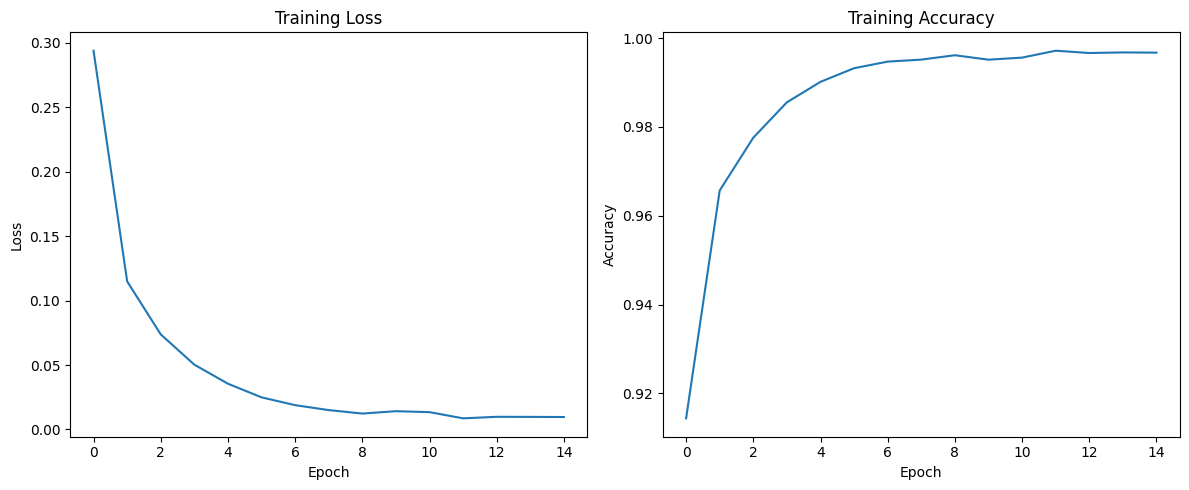

In [7]:
# Modified network architecture for 28x28 images
dense1 = Layer_Dense(784, 256)  # Input: 784 (28x28), First hidden layer: 256 neurons
activation1 = Activation_ReLU()

dense2 = Layer_Dense(256, 128)   # Second hidden layer: 128 neurons
activation2 = Activation_ReLU()

dense3 = Layer_Dense(128, 10)    # Output layer: 10 neurons (for 0-9 digits)
activation3 = Activation_Softmax()

# Loss function and optimizer
loss_function = Loss_crossentropy()
optimizer = Optimizer_Adam(learning_rate=0.001)  # Reduced learning rate

# Training parameters
epochs = 15
loss_history = []
accuracy_history = []

# Load and prepare MNIST dataset (replace with your custom dataset loader)
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess data
X_train = X_train.reshape(-1, 28*28).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28*28).astype('float32') / 255.0

# Training loop with batch processing
batch_size = 128
steps = len(X_train) // batch_size

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for step in range(steps):
        # Create batch
        batch_X = X_train[step*batch_size:(step+1)*batch_size]
        batch_y = y_train[step*batch_size:(step+1)*batch_size]

        # Forward pass
        dense1.forward(batch_X)
        activation1.forward(dense1.output)

        dense2.forward(activation1.output)
        activation2.forward(dense2.output)

        dense3.forward(activation2.output)
        activation3.forward(dense3.output)

        # Compute loss
        loss = loss_function.calculate(activation3.output, batch_y)
        epoch_loss += loss

        # Calculate accuracy
        predictions = np.argmax(activation3.output, axis=1)
        accuracy = np.mean(predictions == batch_y)
        epoch_accuracy += accuracy

        # Backward pass
        loss_function.backward(activation3.output, batch_y)
        activation3.backward(loss_function.dinputs)
        dense3.backward(activation3.dinputs)
        activation2.backward(dense3.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)

        # Update weights
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)
        optimizer.post_update_params()

    # Store epoch metrics
    loss_history.append(epoch_loss / steps)
    accuracy_history.append(epoch_accuracy / steps)

    print(f"Epoch: {epoch}, Loss: {loss_history[-1]:.3f}, Accuracy: {accuracy_history[-1]:.3f}")

# Plot training progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_history)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [8]:
# Add this after training
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
test_loss = loss_function.calculate(activation3.output, y_test)
test_accuracy = np.mean(np.argmax(activation3.output, axis=1) == y_test)
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}, Test Loss: {test_loss:.3f}")


Final Test Accuracy: 0.978, Test Loss: 0.099


In [11]:
# Saving
np.savez('mnist_model.npz',
         dense1_weights=dense1.weights, dense1_biases=dense1.biases,
         dense2_weights=dense2.weights, dense2_biases=dense2.biases,
         dense3_weights=dense3.weights, dense3_biases=dense3.biases)

# Loading
loaded = np.load('mnist_model.npz')
# Load ALL layers (critical!)
dense1.weights = loaded['dense1_weights']
dense1.biases = loaded['dense1_biases']
dense2.weights = loaded['dense2_weights']  # Added
dense2.biases = loaded['dense2_biases']    # Added
dense3.weights = loaded['dense3_weights']  # Added
dense3.biases = loaded['dense3_biases']    # Added

In [12]:
from PIL import Image

def preprocess_image(img_path):
    img = Image.open(img_path).convert('L')  # Grayscale
    img = img.resize((28, 28))               # Resize
    img_array = 1.0 - (np.array(img) / 255.0)  # Invert & normalize
    return img_array.reshape(1, 784)         # Flatten

In [14]:
from PIL import Image

# 1. Load Saved Model Parameters
def load_model():
    # Initialize layers with original architecture
    global dense1, dense2, dense3
    dense1 = Layer_Dense(784, 256)
    dense2 = Layer_Dense(256, 128)
    dense3 = Layer_Dense(128, 10)

    # Load saved weights and biases
    loaded = np.load('mnist_model.npz')

    dense1.weights = loaded['dense1_weights']
    dense1.biases = loaded['dense1_biases']

    dense2.weights = loaded['dense2_weights']
    dense2.biases = loaded['dense2_biases']

    dense3.weights = loaded['dense3_weights']
    dense3.biases = loaded['dense3_biases']

In [15]:
# 2. Image Preprocessing Function
def preprocess_image(img_path):
    # Open and convert to grayscale
    img = Image.open(img_path).convert('L')

    # Resize to 28x28 pixels
    img = img.resize((28, 28))

    # Convert to numpy array and normalize
    img_array = np.array(img)

    # Invert colors (MNIST has white digits on black background)
    img_array = 255 - img_array

    # Normalize and flatten
    img_array = img_array.astype('float32') / 255.0
    return img_array.reshape(1, 784)  # Reshape to (1, 784)

In [16]:
# 3. Prediction Function
def predict_digit(img_path):
    # Load model
    load_model()

    # Preprocess image
    processed_image = preprocess_image(img_path)

    # Forward pass
    dense1.forward(processed_image)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    # Get prediction
    probabilities = activation3.output[0]
    predicted_digit = np.argmax(probabilities)
    confidence = np.max(probabilities)

    return predicted_digit, confidence

In [17]:
# 4. Visualization and Execution
def recognize_digit(img_path):
    # Get prediction
    digit, confidence = predict_digit(img_path)

    # Display results
    plt.figure(figsize=(8,4))

    # Original image
    plt.subplot(1,2,1)
    img = Image.open(img_path).convert('L')
    plt.imshow(img, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Preprocessed image
    plt.subplot(1,2,2)
    processed_img = preprocess_image(img_path).reshape(28,28)
    plt.imshow(processed_img, cmap='gray')
    plt.title(f'Prediction: {digit}\nConfidence: {confidence:.2%}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

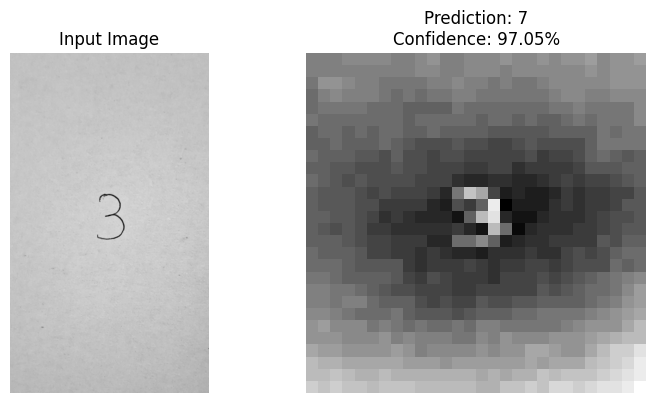

In [18]:
# Usage Example
recognize_digit('/content/3img.jpg')